In [1]:
import os, yerbamate, ipdb
import pandas as pd
import igraph as ig
import leidenalg as la
import matplotlib.pyplot as plt

env = yerbamate.Environment()

path = os.path.join(env["plots"], "analysis", "user_hashtag.parquet")

df = pd.read_parquet(path)

print("Filtering DataFrame...")

hashtag_counts = df.groupby("hashtag").size().reset_index(name="counts")
top_hashtags = hashtag_counts.sort_values("counts", ascending=False).head(2000)
# create a set of the top hashtags for faster lookup
top_hashtags_set = set(top_hashtags["hashtag"])

# filter the original DataFrame
df_filtered = df[df["hashtag"].isin(top_hashtags_set)]

df = df_filtered

# prrint number of unique users and hashtags
print(f"Number of unique users: {len(df['userId'].unique())}")
print(f"Number of unique hashtags: {len(df['hashtag'].unique())}")

print("Creating graph...")
# initialize a new graph
g = ig.Graph(directed=False)
# g.add_vertex(n=len(df["userId"].unique()), type="user")
# g.add_vertex(n=len(df["hashtag"].unique()), type="hashtag")
user_size = len(df["userId"].unique())


g.add_vertices(n=len(df["userId"].unique()) + len(df["hashtag"].unique()))

# set name of hashtags to be the hashtag itself
g.vs[user_size:]["name"] = df["hashtag"].unique()

# Add types for vertices
g.vs["type"] = [True if i < user_size else False for i in range(g.vcount())]


print("Added vertices...")
# map users and hashtags to unique integers
user_mapping = {user: i for i, user in enumerate(df["userId"].unique())}
hashtag_mapping = {
    hashtag: i + len(user_mapping) for i, hashtag in enumerate(df["hashtag"].unique())
}

print("Computing edges...")
# add edges
# edges = [
#     (user_mapping[row["userId"]], hashtag_mapping[row["hashtag"]])
#     for idx, row in df.iterrows()
# ]

df["user_id"] = df["userId"].map(user_mapping)
df["hashtag_id"] = df["hashtag"].map(hashtag_mapping)

# create the list of edges
edges = list(zip(df["user_id"], df["hashtag_id"]))

print("Adding edges...")

g.add_edges(edges)

# weights = df["count"].values

# # add the edges with weights
# g.es["weight"] = weightsu

# # add the edges with weights
# g.es['weight'] = weights
print("Number of vertices: ", len(g.vs))
print("Number of edges: ", len(g.es))

print("Finding communities...")


# import the leidenalg library

# get the partition using the Leiden algorithm
# partition = la.find_partition(g, la.ModularityVertexPartition, weights=None)

#print("Number of communities: ", len(partition))



Filtering DataFrame...
Number of unique users: 457568
Number of unique hashtags: 2000
Creating graph...
Added vertices...
Computing edges...
Adding edges...
Number of vertices:  459568
Number of edges:  11084683
Finding communities...


In [ ]:
# Create bipartite projection
# g.vs["type"] = [True if node_type == "user" else False for node_type in g.vs["type"]]

print("Creating bipartite projection...")

user_projection, hashtag_projection = g.bipartite_projection(multiplicity=False)

user_projection.write("user_projection.graphml", format="graphml")
hashtag_projection.write("hashtag_projection.graphml", format="graphml")
print("User projection: ", user_projection.summary())
print("Hashtag projection: ", hashtag_projection.summary())

# Find communities in user projection
user_partition = la.find_partition(user_projection, la.ModularityVertexPartition)

print("Number of communities in user projection: ", len(user_partition))

# Find communities in hashtag projection
hashtag_partition = la.find_partition(hashtag_projection, la.ModularityVertexPartition)

print("Number of communities in hashtag projection: ", len(hashtag_partition))


In [1]:
import os, yerbamate
import pandas as pd
import igraph as ig
from collections import defaultdict
from itertools import combinations

env = yerbamate.Environment()

path = os.path.join(env["plots"], "analysis", "user_hashtag.parquet")

df = pd.read_parquet(path)

print("Filtering DataFrame...")

hashtag_counts = df.groupby("hashtag").size().reset_index(name="counts")
top_hashtags = hashtag_counts.sort_values("counts", ascending=False).head(2000)
# create a set of the top hashtags for faster lookup
top_hashtags_set = set(top_hashtags["hashtag"])

# filter the original DataFrame
df_filtered = df[df["hashtag"].isin(top_hashtags_set)]
df = df_filtered

# print number of unique users and hashtags
print(f"Number of unique users: {len(df['userId'].unique())}")
print(f"Number of unique hashtags: {len(df['hashtag'].unique())}")

print("Creating graph...")
# initialize a new graph
g = ig.Graph(directed=False)

# Add vertices
g.add_vertices(n=len(df['userId'].unique()))

# map users to unique integers
user_mapping = {user: i for i, user in enumerate(df['userId'].unique())}

# map back from index to user for later use
index_to_user = {i: user for user, i in user_mapping.items()}

# add the mapped user ids to the dataframe
df['user_id'] = df['userId'].map(user_mapping)

# create a dictionary where keys are hashtags and values are lists of users that used this hashtag
hashtag_to_users = df.groupby('hashtag')['user_id'].apply(list).to_dict()

print("Computing edges...")

# Create edges between users who share the same hashtag
edges = set()
for users in hashtag_to_users.values():
    if len(users) > 1:
        edges.update(combinations(users, 2))

print("Adding edges...")
g.add_edges(list(edges))

# save graph to file
save_path = os.path.join(env['plots'], 'analysis', 'user_hashtag_graph.gml')
g.write_gml(save_path)

print("Number of vertices: ", len(g.vs))
print("Number of edges: ", len(g.es))

print("Finding communities...")
# import the leidenalg library
import leidenalg as la
# get the partition using the Leiden algorithm
partition = la.find_partition(g, la.ModularityVertexPartition)

print("Number of communities: ", len(partition))


Filtering DataFrame...
Number of unique users: 457568
Number of unique hashtags: 2000
Creating graph...
Computing edges...


In [37]:
g.es["weight"] = weights
partition = la.find_partition(g, la.ModularityVertexPartition, weights=weights)
print("Number of communities: ", len(partition))

Number of communities:  37


In [38]:
g.vs["community"] = partition.membership

#g.save("graph.graphml", format="graphml")

In [39]:
# Assume user_community is a dictionary mapping user id to community id
user_community = {user_id: community_id for user_id, community_id in zip(user_mapping.keys(), partition.membership)}

# Create a new column in the DataFrame with the community id
df['community'] = df['userId'].map(user_community)


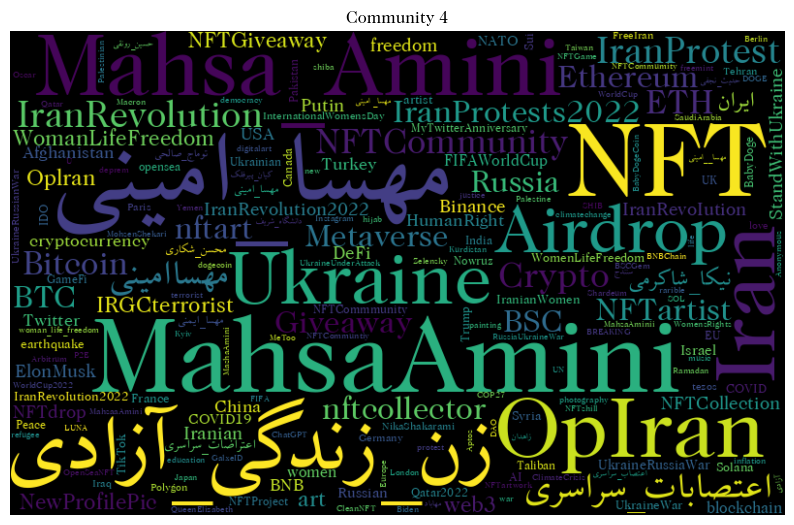

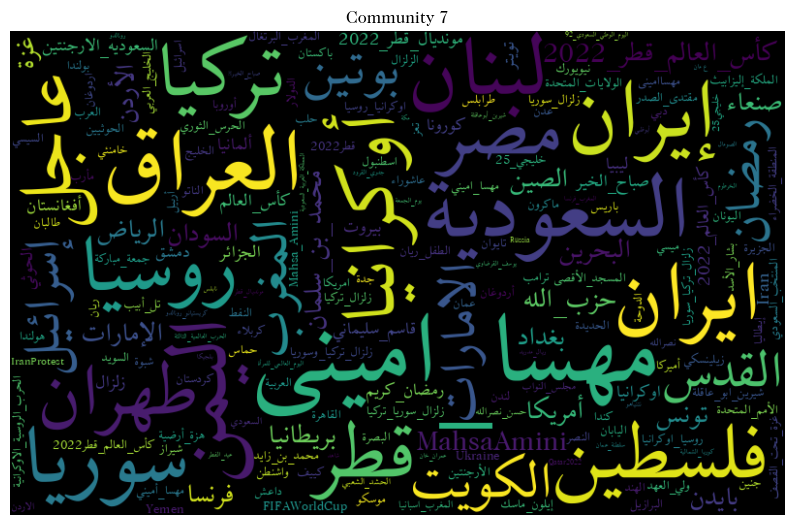

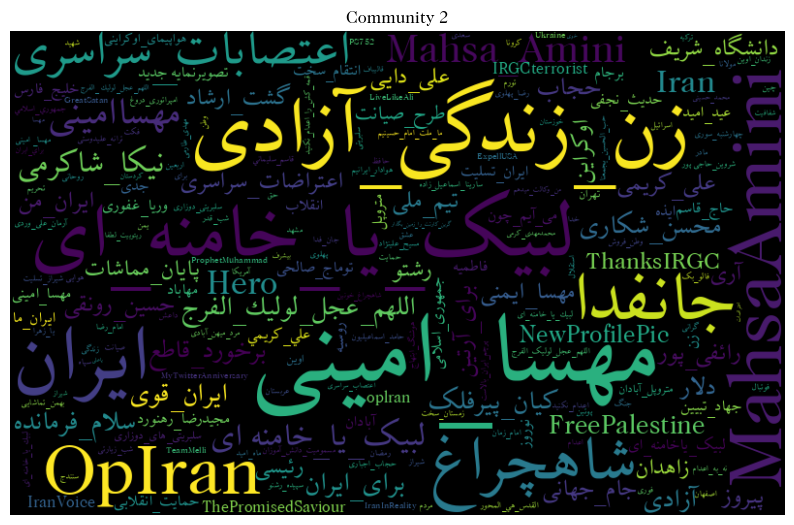

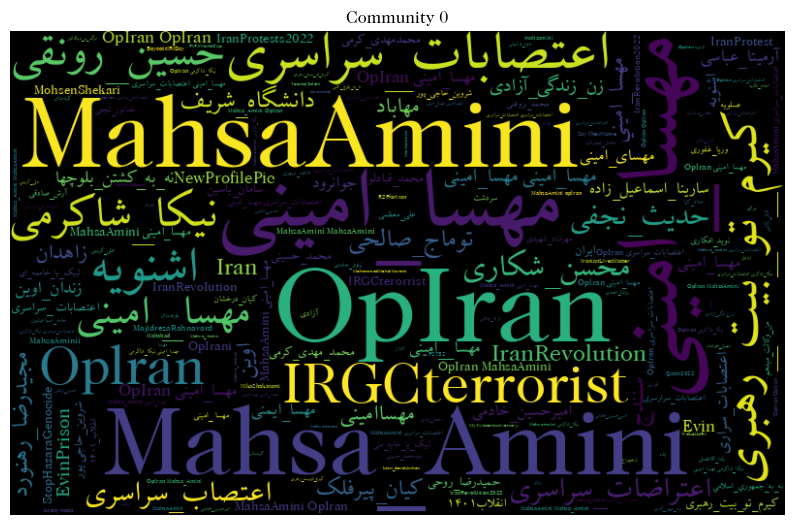

KeyboardInterrupt: 

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["axes.unicode_minus"] = False
from bidi.algorithm import get_display
import arabic_reshaper

# assuming `df` is your DataFrame and it has a 'community' column
for community in df['community'].unique():
    subset = df[df['community'] == community]
    text = ' '.join(subset['hashtag'].values)
    # text = get_display(arabic_reshaper.reshape(text))
    
    wordcloud = WordCloud(font_path='/usr/share/fonts/TTF/XB-Zar-Regular.ttf',width=800, height=500, random_state=21, max_font_size=110).generate(text)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Community {community}")
    plt.show()


In [33]:
sample_size = 4500

# 2. Sample nodes
# Group nodes by community
groups = df.groupby('community')

# Sample from each group
sampled_nodes = groups.apply(lambda x: x.sample(n=int((x['userId'].nunique()/df['userId'].nunique())*sample_size)))

# Get the unique sampled userIds
sampled_ids = sampled_nodes['userId'].unique()

# 3. Create a subgraph
# Get the vertex indices corresponding to the sampled user Ids
vertex_indices = [g.vs.find(name=str(i)).index for i in sampled_ids if str(i) in g.vs['name']]

# Create a subgraph
subgraph = g.subgraph(vertex_indices)

# Plot the subgraph


In [34]:
import networkx as nx
from pyvis.network import Network


# Convert igraph to networkx
G_nx = ig.Graph.to_networkx(subgraph)

# Create a pyvis network
G_pyvis = Network(notebook=True)
G_pyvis.from_nx(G_nx)

# Show the network
G_pyvis.show("graph.html")

graph.html
